<a href="https://colab.research.google.com/github/happy-jihye/Natural-Language-Processing/blob/main/Sequence_to_Sequence_with_Neural_Networks/Sequence_to_Sequence_with_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequence to Sequence Learning with Neural Networks (NIPS 2014)** 

- [Paper](https://arxiv.org/pdf/1409.3215.pdf)
- 2021/03/11, Jihye Back
- seq2seq model을 이용한 번역 예제 (pytorch/torchtext)



## 1. Introduction

- Sequence-to-Sequence(Seq2Seq) model은 대표적인 encoder-decoder model로서, multilayered LSTM을 사용
- Source sentence(input)을 encoder에 넣으면 RNN(recurrent neural network)를 지나 하나의 context vector로 압축이 됨
- 이때 context vector는 fixed dimension이며, 이 single vector를 다시 decoder에 넣은 후 RNN로 decoding을 하면 target vector가 구해짐

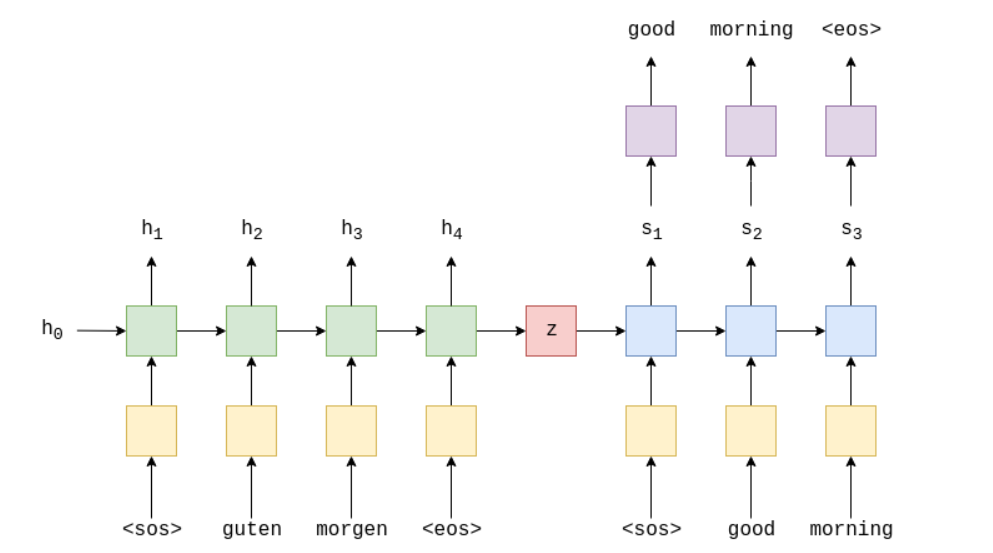



- 위의 이미지는 간단한 번역 예제
- "guten morgen"이라는 input/source sentencee를 embedding layer(yellow)에 넣은 후 다시 encoder(green)에 넣음
  > 이때, <sos> (start of sequence)와 <eos>(end of sequence)를 넣음으로써 문장의 시작과 끝이 어디인지를 알려줌.


---

### **Preparing Data**

* **spaCy 라이브러리**: 문장의 토큰화(tokenization), 태깅(tagging) 등의 전처리 기능을 위한 라이브러리
  * 영어(Engilsh)와 독일어(Deutsch) 전처리 모듈 설치
  * spacy는 영어 이외의 다양한 언어에 대해서도 강력한 토큰화 기능을 제공하기 때문에 사용

In [43]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [44]:
import spacy

spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

In [45]:
# spacy를 이용한 tokenization
tokenized = spacy_en.tokenizer("I am a graduate student.")
doc = spacy_en("I am a graduate student.")

# 1)
for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")
# 2)
for token in doc:
    print(token.text)

인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student
인덱스 5: .
I
am
a
graduate
student
.


* 영어(English) 및 독일어(Deutsch) **토큰화 함수(tokenizer functions)** 

In [46]:
# 독일어(Deutsch) 문장을 토큰화한 뒤에 순서를 뒤집는 함수
## 이 논문에서는 source sentences의 문장을 뒤집으면 LSTM의 성능이 놀랄만큼 향상된다고 말하고 있음(최적화가 더 잘되기 때문)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)][::-1]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

* **필드(field)** 에 정의된 내용을 기반으로 토큰화
* SRC -> TRG 로 번역
  * source(SRC): German
  * target(TRG): English

In [47]:
!pip install -U torchtext==0.8.0

Requirement already up-to-date: torchtext==0.8.0 in /usr/local/lib/python3.7/dist-packages (0.8.0)


In [48]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


* 대표적인 영어-독어 번역 데이터셋인 **Multi30k**를 불러옵니다.

In [49]:
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [50]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


In [51]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[30]))
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

{'src': ['.', 'steht', 'urinal', 'einem', 'an', 'kaffee', 'tasse', 'einer', 'mit', 'der', ',', 'mann', 'ein'], 'trg': ['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']}
['.', 'steht', 'urinal', 'einem', 'an', 'kaffee', 'tasse', 'einer', 'mit', 'der', ',', 'mann', 'ein']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


* torchtext의 **필드(field)** 객체의 **build_vocab** 메서드를 이용해 영어와 독어의 단어 사전을 생성합니다.
  * **최소 2번 이상** 등장한 단어만을 선택합니다.(min_freq=2)

In [52]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7855
len(TRG): 5893


- SRC.vocab.stoi 는 어휘에 해당하는 토큰을 key로, 관련된 index을 value으로 가지는 사전(dict)이 됩니다. 
- SRC.vocab.itos 역시 사전(dict)이지만, key와 value이 서로 반대입니다.

In [84]:
print(SRC.vocab)
print(f"\nstoi : {SRC.vocab.stoi}")
print(f"\nitos : {SRC.vocab.itos}")


stoi : defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7ff3a1076790>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'mädchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'männer': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'straße': 34, 'während': 35, 'gruppe': 36, 'hält': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, 'über': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'weißen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'trägt': 61, 'fährt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 'springt': 69, 'kleiner': 70, 'schwarze

In [53]:
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


* 한 문장에 포함된 단어가 연속적으로 **LSTM**에 입력되어야 합니다.
    * 따라서 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋습니다.
    * 이를 위해 BucketIterator를 사용합니다.
      > BucketIterator는 비슷한 길이의 예제들을 묶어주는 iterator(반복자)를 정의합니다. 각각의 새로운 epoch마다 새로 섞인 결과를 만드는데 필요한 패딩 수를 최소화합니다.
    * **배치 크기(batch size)**: 128

In [54]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [55]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[0]):
        print(f"인덱스 {i}: {src[i][0].item()}")

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([32, 128])
인덱스 0: 2
인덱스 1: 4
인덱스 2: 148
인덱스 3: 5
인덱스 4: 85
인덱스 5: 500
인덱스 6: 450
인덱스 7: 6
인덱스 8: 7
인덱스 9: 25
인덱스 10: 5
인덱스 11: 10
인덱스 12: 26
인덱스 13: 5
인덱스 14: 3
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1
인덱스 29: 1
인덱스 30: 1
인덱스 31: 1


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


---
# Building the Seq2Seq Model
- 세가지 part로 model을 나눠서 구현할 것
  
  1) The encoder 
  
  2) The Decoder
  
  3) seq2seq model : encoder와 decoder를 캡슐화한 후 각각을 interface함 

---
### 1) Encoder

- 이 논문에서는 4-layer LSTM을 사용하고 있으나 이 예제에서는 2-layer LSTM을 사용하였음
- bottom layer에서는 input sentence를 embedding해야함.
- 두번째 layer부터는 이전 layer의 hidden state를 가지고 encoding을 함
$$\begin{align*}
(h_t^1, c_t^1) = \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) = \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$


- layer가 두개라면 아래와 같은 형태의 encoder가 생김


  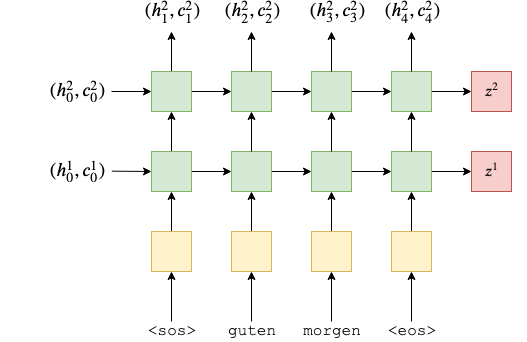


* 주어진 소스 문장을 **문맥 벡터(context vector)로 인코딩**함.
* LSTM은 hidden state과 cell state을 반환
* 하이퍼 파라미터(hyperparameter)
    * **input_dim**: 하나의 단어에 대한 원핫 인코딩 차원
    * **embed_dim**: 임베딩(embedding) 차원
    * **hidden_dim**: 히든 상태(hidden state) 차원
    * **n_layers**: RNN 레이어의 개수
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [90]:
import torch.nn as nn

# 인코더(Encoder) 아키텍처 정의
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        # 임베딩(embedding)은 원-핫 인코딩(one-hot encoding)을 특정 차원의 임베딩으로 매핑하는 레이어
        self.embedding = nn.Embedding(input_dim, embed_dim)

        # LSTM 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout_ratio)
        
        # 드롭아웃(dropout)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더는 소스 문장을 입력으로 받아 문맥 벡터(context vector)를 반환        
    def forward(self, src):

        # src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src len, batch size, emb dim]

        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src len, batch size, hid dim * n directions] : 현재 단어의 출력 정보
        # hidden = [n layers * n directions, batch size, hid dim] : 현재까지의 모든 단어의 정보
        # cell = [n layers * n directions, batch size, hid dim] : 현재까지의 모든 단어의 정보

        # 문맥 벡터(context vector) 반환
        return hidden, cell

## 2) Decoder

- context vector를 바탕으로 decoding을 함

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$

* 주어진 문맥 벡터(context vector)를 **타겟 문장으로 디코딩**함
* LSTM은 hidden state과 cell state을 반환
* 하이퍼 파라미터(hyperparameter)
    * **input_dim**: 하나의 단어에 대한 원핫 인코딩 차원
    * **embed_dim**: 임베딩(embedding) 차원
    * **hidden_dim**: 히든 상태(hidden state) 차원
    * **n_layers**: RNN 레이어의 개수
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [91]:
# 디코더(Decoder) 아키텍처 정의
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        # 임베딩(embedding)은 원-핫 인코딩(one-hot encoding) 말고 특정 차원의 임베딩으로 매핑하는 레이어
        self.embedding = nn.Embedding(output_dim, embed_dim)

        # LSTM 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout_ratio)
        
        # FC 레이어 (인코더와 구조적으로 다른 부분)
        self.output_dim = output_dim
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
        # 드롭아웃(dropout)
        self.dropout = nn.Dropout(dropout_ratio)

    # 디코더는 현재까지 출력된 문장에 대한 정보를 입력으로 받아 타겟 문장을 반환     
    def forward(self, input, hidden, cell):

        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        input = input.unsqueeze(0)
        #input = [1, batch size] : source length가 1 (단어의 개수)
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # output = [seq len = 1, batch size, hid dim * n directions] : 현재 단어의 출력 정보
        # hidden = [n layers * n directions, batch size, hid dim] : 현재까지의 모든 단어의 정보
        # cell = [n layers * n directions, batch size, hid dim] : 현재까지의 모든 단어의 정보

        # 단어 개수는 어차피 1개이므로 차원 제거
        prediction = self.fc_out(output.squeeze(0))
        #prediction = [batch size, output dim]
        
        # (현재 출력 단어, 현재까지의 모든 단어의 정보, 현재까지의 모든 단어의 정보)
        return prediction, hidden, cell

### 3) Seq2Seq 

* 앞서 정의한 인코더(encoder)와 디코더(decoder)를 가지고 있는 하나의 아키텍처입니다.
    * **인코더(encoder)**: 주어진 소스 문장을 문맥 벡터(context vector)로 인코딩합니다.
    * **디코더(decoder)**: 주어진 문맥 벡터(context vector)를 타겟 문장으로 디코딩합니다.
    * 단, **디코더는 한 단어씩** 넣어서 한 번씩 결과를 구합니다.
* **Teacher forcing**: 디코더의 예측(prediction)을 다음 입력으로 사용하지 않고, 실제 목표 출력(ground-truth)을 다음 입력으로 사용하는 기법

In [92]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    # 학습할 때는 완전한 형태의 소스 문장, 타겟 문장, teacher_forcing_ratio를 넣기
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        
        # 먼저 인코더를 거쳐 문맥 벡터(context vector)를 추출
        hidden, cell = self.encoder(src)

        # 디코더(decoder)의 최종 결과를 담을 텐서 객체 만들기
        trg_len = trg.shape[0] # 단어 개수
        batch_size = trg.shape[1] # 배치 크기
        trg_vocab_size = self.decoder.output_dim # 출력 차원
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # 첫 번째 입력은 항상 <sos> 토큰
        input = trg[0, :]

        # 타겟 단어의 개수만큼 반복하여 디코더에 포워딩(forwarding)
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)

            outputs[t] = output # FC를 거쳐서 나온 현재의 출력 단어 정보
            top1 = output.argmax(1) # 가장 확률이 높은 단어의 인덱스 추출

            # teacher_forcing_ratio: 학습할 때 실제 목표 출력(ground-truth)을 사용하는 비율
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else top1 # 현재의 출력 결과를 다음 입력에서 넣기
        
        return outputs

#### **학습(Training)**

* 하이퍼 파라미터 설정 및 모델 초기화

In [122]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENCODER_EMBED_DIM = 256
DECODER_EMBED_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
ENC_DROPOUT_RATIO = 0.5
DEC_DROPOUT_RATIO = 0.5

In [123]:
# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, ENCODER_EMBED_DIM, HIDDEN_DIM, N_LAYERS, ENC_DROPOUT_RATIO)
dec = Decoder(OUTPUT_DIM, DECODER_EMBED_DIM, HIDDEN_DIM, N_LAYERS, DEC_DROPOUT_RATIO)

# Seq2Seq 객체 선언
model = Seq2Seq(enc, dec, device).to(device)

* 논문의 내용대로 $\mathcal{U}(-0.08, 0.08)$의 값으로 **모델 가중치 파라미터 초기화**

In [124]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

* 학습 및 평가 함수 정의

In [125]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
optimizer = optim.Adam(model.parameters())

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [126]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0
    
    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()

        output = model(src, trg)
        # output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        # 출력 단어의 인덱스 0은 사용하지 않음
        output = output[1:].view(-1, output_dim)
        # output = [(trg len - 1) * batch size, output dim]

        trg = trg[1:].view(-1)
        # trg = [(trg len - 1) * batch size]
        
        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산
        
        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # 파라미터 업데이트
        optimizer.step()
        
        # 전체 손실 값 계산
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [127]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0
    
    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 평가할 때 teacher forcing는 사용하지 않음
            output = model(src, trg, 0)
            # output = [trg len, batch size, output dim]
            output_dim = output.shape[-1]
            
            # 출력 단어의 인덱스 0은 사용하지 않음
            output = output[1:].view(-1, output_dim)
            # output = [(trg len - 1) * batch size, output dim]
            trg = trg[1:].view(-1)
            # trg = [(trg len - 1) * batch size]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

* 학습(training) 및 검증(validation) 진행
    * **학습 횟수(epoch)**: 20

In [128]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [129]:
import time
import math
import random

N_EPOCHS = 20
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 36s
	Train Loss: 5.056 | Train PPL: 156.897
	Validation Loss: 4.981 | Validation PPL: 145.666
Epoch: 02 | Time: 0m 35s
	Train Loss: 4.519 | Train PPL: 91.777
	Validation Loss: 4.785 | Validation PPL: 119.739
Epoch: 03 | Time: 0m 35s
	Train Loss: 4.244 | Train PPL: 69.658
	Validation Loss: 4.596 | Validation PPL: 99.075
Epoch: 04 | Time: 0m 35s
	Train Loss: 4.047 | Train PPL: 57.219
	Validation Loss: 4.511 | Validation PPL: 91.039
Epoch: 05 | Time: 0m 35s
	Train Loss: 3.900 | Train PPL: 49.404
	Validation Loss: 4.433 | Validation PPL: 84.195
Epoch: 06 | Time: 0m 35s
	Train Loss: 3.790 | Train PPL: 44.237
	Validation Loss: 4.402 | Validation PPL: 81.636
Epoch: 07 | Time: 0m 35s
	Train Loss: 3.685 | Train PPL: 39.854
	Validation Loss: 4.309 | Validation PPL: 74.382
Epoch: 08 | Time: 0m 35s
	Train Loss: 3.585 | Train PPL: 36.047
	Validation Loss: 4.261 | Validation PPL: 70.851
Epoch: 09 | Time: 0m 35s
	Train Loss: 3.477 | Train PPL: 32.353
	Validation Loss: 4.171 | Val

In [130]:
# 학습된 모델 저장
from google.colab import files

files.download('seq2seq.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **모델 최종 테스트(testing) 결과 확인**

In [131]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERgwTMYWR7FMhApROaNvZREBTjEDi00ttSzt8ZNj1PS_5g?download=1 -O seq2seq.pt

--2021-03-11 06:37:49--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERgwTMYWR7FMhApROaNvZREBTjEDi00ttSzt8ZNj1PS_5g?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/seq2seq.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FUmd3VE1ZV1I3Rk1oQXBST2FOdlpSRUJUakVEaTAwdHRTenQ4Wk5qMVBTXzVnP3J0aW1lPVVlUE1NRmprMkVn [following]
--2021-03-11 06:37:50--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/seq2seq.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FUmd3VE1ZV1I3Rk1oQXBST2FOdlpSRUJUakVEaTAwdHRTenQ4W

In [132]:
model.load_state_dict(torch.load('seq2seq.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 3.593 | Test PPL: 36.330


#### **나만의 데이터로 모델 사용해보기**

In [133]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # 인코더(endocer)에 소스 문장을 넣어 문맥 벡터(context vector) 계산
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        # 이전에 출력한 단어가 현재 단어로 입력될 수 있도록
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:]

In [134]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')
print("모델 출력 결과:", " ".join(translate_sentence(src, SRC, TRG, model, device)))

소스 문장: ['.', 'freien', 'im', 'tag', 'schönen', 'einen', 'genießen', 'sohn', 'kleiner', 'ihr', 'und', 'mutter', 'eine']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰: ['<sos>', '.', 'freien', 'im', 'tag', 'schönen', 'einen', 'genießen', 'sohn', 'kleiner', 'ihr', 'und', 'mutter', 'eine', '<eos>']
소스 문장 인덱스: [2, 4, 88, 20, 200, 780, 19, 565, 624, 70, 134, 10, 364, 8, 3]
모델 출력 결과: a mother and her little boys enjoying a day day day . <eos>


In [135]:
src = tokenize_de("Guten Abend.")

print(f'소스 문장: {src}')
print("모델 출력 결과:", " ".join(translate_sentence(src, SRC, TRG, model, device)))

소스 문장: ['.', 'Abend', 'Guten']
전체 소스 토큰: ['<sos>', '.', 'abend', 'guten', '<eos>']
소스 문장 인덱스: [2, 4, 1163, 3799, 3]
모델 출력 결과: at night . <eos>


## Reference
- [bentrevett/pytorch-seq2seq](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)
- [ndb796
/
Deep-Learning-Paper-Review-and-Practice](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Sequence_to_Sequence_with_LSTM_Tutorial.ipynb)
- [pytorch](https://tutorials.pytorch.kr/beginner/torchtext_translation_tutorial.html)
